In [1]:
# Importación de Librerías Esenciales

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


<div class="alert alert-block alert-info">
    <h1>Taller Práctico: Regresión Lineal, Ridge y Lasso</h1>
    <p><strong>Objetivos de la sesión:</strong></p>
    <ul>
        <li>Aplicar los conceptos de regresión lineal en un problema práctico.</li>
        <li>Implementar y comparar modelos de Regresión Lineal, Ridge y Lasso.</li>
        <li>Utilizar la validación cruzada para encontrar el hiperparámetro de regularización óptimo.</li>
        <li>Evaluar el rendimiento de los modelos utilizando métricas como MSE, MAE y R².</li>
    </ul>
    <p><strong>Dataset:</strong> Utilizaremos el dataset "Ames Housing", que contiene información sobre la venta de casas en Ames, Iowa. Nuestro objetivo será predecir el precio de venta (<code>SalePrice</code>) de las casas.</p>
</div>

### 1. Carga y Exploración de Datos (EDA)

<p>El primer paso en cualquier proyecto de Machine Learning es entender nuestros datos. Cargaremos el dataset, veremos su estructura y realizaremos algunas visualizaciones iniciales.</p>

In [2]:
# Cargar el dataset Ames Housing desde OpenML
housing = fetch_openml(name="house_prices", as_frame=True)
df = housing.frame

# Seleccionamos un subconjunto de características numéricas para simplificar el taller
# y la variable objetivo 'SalePrice'
numeric_features = ['GrLivArea', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'FullBath', 'GarageCars']
target_variable = 'SalePrice'

# Creamos un DataFrame más pequeño y manejamos valores faltantes de forma simple
df_subset = df[numeric_features + [target_variable]].dropna()

print(f"\nDimensiones del subconjunto de datos: {df_subset.shape}")
print("\nDescripción estadística del subconjunto:")
print(df_subset.describe())


Dimensiones del subconjunto de datos: (1460, 7)

Descripción estadística del subconjunto:
         GrLivArea  OverallQual    YearBuilt  TotalBsmtSF     FullBath  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1515.463699     6.099315  1971.267808  1057.429452     1.565068   
std     525.480383     1.382997    30.202904   438.705324     0.550916   
min     334.000000     1.000000  1872.000000     0.000000     0.000000   
25%    1129.500000     5.000000  1954.000000   795.750000     1.000000   
50%    1464.000000     6.000000  1973.000000   991.500000     2.000000   
75%    1776.750000     7.000000  2000.000000  1298.250000     2.000000   
max    5642.000000    10.000000  2010.000000  6110.000000     3.000000   

        GarageCars      SalePrice  
count  1460.000000    1460.000000  
mean      1.767123  180921.195890  
std       0.747315   79442.502883  
min       0.000000   34900.000000  
25%       1.000000  129975.000000  
50%       2.000000  163000

<p>Ahora, visualicemos la distribución de nuestra variable objetivo y la relación entre el área de la vivienda y su precio. La distribución de precios está sesgada, por lo que una transformación logarítmica será útil.</p>

In [3]:
# Ahora puedes mostrar los gráficos sin error
fig_hist = px.histogram(df_subset, x='SalePrice', nbins=50, title='Distribución del Precio de Venta de las Casas (Original)')
fig_hist.update_layout(xaxis_title='Precio de Venta (USD)', yaxis_title='Frecuencia')
fig_hist.show()

fig_hist_log = px.histogram(x=np.log1p(df_subset['SalePrice']), nbins=50, title='Distribución del log(Precio de Venta)')
fig_hist_log.update_layout(xaxis_title='log(1 + Precio de Venta)', yaxis_title='Frecuencia')
fig_hist_log.show()

### 2. Preparación de Datos

<p>Ahora aplicaremos los cambios necesarios: división de datos, transformación logarítmica del objetivo y escalado de características.</p>

In [4]:
# 1. Definir características (X) y objetivo (y)
X = df_subset[numeric_features]
y_raw = df_subset[target_variable] # Guardamos el 'y' original para evaluación final

# !! CAMBIO CLAVE !!
# Aplicamos la transformación logarítmica a la variable objetivo 'y'
# Esto estabiliza la varianza y normaliza la escala del problema.
y = np.log1p(y_raw)

# 2. Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# 3. Escalar las características numéricas
scaler = StandardScaler()

# Ajustamos el escalador SOLO con los datos de entrenamiento para evitar fuga de datos (data leakage)
X_train_scaled = scaler.fit_transform(X_train)
# Aplicamos la misma transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Convertimos los arrays de numpy de vuelta a DataFrames de pandas para mejor legibilidad
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)

Tamaño del set de entrenamiento: (1168, 6)
Tamaño del set de prueba: (292, 6)


### 3. Regresión Lineal (Mínimos Cuadrados Ordinarios)

<p>Entrenamos nuestro modelo base con los datos transformados. El MSE será un número pequeño y manejable.</p>

In [5]:
# Crear y entrenar el modelo de Regresión Lineal
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba (las predicciones estarán en escala logarítmica)
y_pred_ols = ols_model.predict(X_test_scaled)

# Evaluar el modelo
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print("--- Evaluación del Modelo de Regresión Lineal (OLS) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_ols:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_ols:.4f}")

# Ver los coeficientes del modelo
coef_df = pd.DataFrame(ols_model.coef_, index=numeric_features, columns=['Coeficiente_OLS'])
print("\nCoeficientes del modelo OLS:")
print(coef_df)

--- Evaluación del Modelo de Regresión Lineal (OLS) ---
Error Cuadrático Medio (MSE en escala log): 0.0303
Coeficiente de Determinación (R²): 0.8375

Coeficientes del modelo OLS:
             Coeficiente_OLS
GrLivArea           0.126585
OverallQual         0.138404
YearBuilt           0.074407
TotalBsmtSF         0.044540
FullBath           -0.006889
GarageCars          0.071504


### 4. Regresión con Regularización: Ridge (L2) y Lasso (L1)

<p>Con el objetivo ya transformado, ahora `alpha` tendrá el efecto esperado. Usaremos un valor pequeño para ver el contraste.</p>

In [6]:
# --- Ridge Regression (L2) ---
ridge_model = Ridge(alpha=100.) # Alpha grande
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("--- Evaluación del Modelo Ridge (alpha=100.) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_ridge:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_ridge:.4f}")

# --- Lasso Regression (L1) ---
lasso_model = Lasso(alpha=0.1) # Alpha pequeño
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Evaluación del Modelo Lasso (alpha=0.1) ---")
print(f"Error Cuadrático Medio (MSE en escala log): {mse_lasso:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_lasso:.4f}")

# Comparar coeficientes
coef_df['Coef_Ridge_alpha100'] = ridge_model.coef_
coef_df['Coef_Lasso_alpha0.1'] = lasso_model.coef_
print("\n--- Comparación de Coeficientes ---")
print(coef_df.round(4))

--- Evaluación del Modelo Ridge (alpha=100.) ---
Error Cuadrático Medio (MSE en escala log): 0.0310
Coeficiente de Determinación (R²): 0.8340

--- Evaluación del Modelo Lasso (alpha=0.1) ---
Error Cuadrático Medio (MSE en escala log): 0.0579
Coeficiente de Determinación (R²): 0.6895

--- Comparación de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1
GrLivArea             0.1266               0.1120               0.0567
OverallQual           0.1384               0.1285               0.1479
YearBuilt             0.0744               0.0673               0.0050
TotalBsmtSF           0.0445               0.0499               0.0060
FullBath             -0.0069               0.0080               0.0000
GarageCars            0.0715               0.0723               0.0486


<p>¡Ahora sí! Observa cómo los coeficientes de Ridge son sistemáticamente más pequeños (encogidos) que los de OLS. Y más importante, mira los coeficientes de Lasso: con un `alpha` de solo 0.1, ¡ya ha reducido el coeficiente de `FullBath` casi a cero, demostrando su poder de selección de características!</p>

### 5. Selección de Hiperparámetros con Validación Cruzada

<p>Finalmente, usamos `RidgeCV` y `LassoCV` para encontrar el `alpha` óptimo de manera automática.</p>

In [7]:
from sklearn.linear_model import RidgeCV

# Definir un rango de alphas para probar
alphas = np.logspace(-4, 2, 100)

# --- RidgeCV ---
# ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_scaled, y_train)

print("--- Búsqueda del mejor Alpha para Ridge ---")
print(f"Mejor alpha encontrado para Ridge: {ridge_cv.alpha_:.4f}")

# Evaluar el modelo Ridge final con el mejor alpha
y_pred_ridge_cv = ridge_cv.predict(X_test_scaled)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)
print(f"MSE de Ridge con CV: {mse_ridge_cv:.4f}")
print(f"R² de Ridge con CV: {r2_ridge_cv:.4f}")

# --- LassoCV ---
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print("\n--- Búsqueda del mejor Alpha para Lasso ---")
print(f"Mejor alpha encontrado para Lasso: {lasso_cv.alpha_:.4f}")

# Evaluar el modelo Lasso final
y_pred_lasso_cv = lasso_cv.predict(X_test_scaled)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)
print(f"MSE de Lasso con CV: {mse_lasso_cv:.4f}")
print(f"R² de Lasso con CV: {r2_lasso_cv:.4f}")

# Añadir los coeficientes finales al DataFrame
coef_df['Coef_Ridge_CV'] = ridge_cv.coef_
coef_df['Coef_Lasso_CV'] = lasso_cv.coef_
print("\n--- Comparación Final de Coeficientes ---")
print(coef_df.round(4))

--- Búsqueda del mejor Alpha para Ridge ---
Mejor alpha encontrado para Ridge: 86.9749
MSE de Ridge con CV: 0.0309
R² de Ridge con CV: 0.8346

--- Búsqueda del mejor Alpha para Lasso ---
Mejor alpha encontrado para Lasso: 0.0043
MSE de Lasso con CV: 0.0307
R² de Lasso con CV: 0.8357

--- Comparación Final de Coeficientes ---
             Coeficiente_OLS  Coef_Ridge_alpha100  Coef_Lasso_alpha0.1  \
GrLivArea             0.1266               0.1120               0.0567   
OverallQual           0.1384               0.1285               0.1479   
YearBuilt             0.0744               0.0673               0.0050   
TotalBsmtSF           0.0445               0.0499               0.0060   
FullBath             -0.0069               0.0080               0.0000   
GarageCars            0.0715               0.0723               0.0486   

             Coef_Ridge_CV  Coef_Lasso_CV  
GrLivArea           0.1135         0.1199  
OverallQual         0.1297         0.1385  
YearBuilt           0.

### 6. Desafíos para Experimentar

<p>Ahora es tu turno de experimentar. Responde a las siguientes preguntas modificando el código anterior:</p>
<ol>
    <li><strong>Añadir más características:</strong> Elige otras 2 o 3 características numéricas del `df` original, añádelas a la lista `numeric_features` y vuelve a ejecutar todo el notebook. ¿Mejora el R² del modelo final?</li>
    <li><strong>Interpretación de coeficientes:</strong> Observa los coeficientes finales del modelo `LassoCV`. ¿Qué característica parece ser la más importante según este modelo? ¿Cuáles ha descartado (coeficiente cercano a cero)?</li>
    <li><strong>Evaluación en escala original:</strong> Las predicciones (`y_pred_lasso_cv`) están en escala logarítmica. Usa `np.expm1()` para convertirlas de nuevo a dólares. Luego, calcula el Error Absoluto Medio (MAE) entre las predicciones revertidas y el `y_test` original (que deberías haber guardado como `y_raw`). ¿Cuál es el error promedio en dólares de tu mejor modelo?</li>
</ol>

### 7. Ejercicios Propuestos

<div class="alert alert-block alert-warning">
<h4>Ejercicios para Solidificar Conceptos</h4>
<ol>
    <li><strong>Evaluación de Residuos:</strong> Para el mejor modelo que encontraste (probablemente RidgeCV o LassoCV), calcula los residuos ($y_{test} - \hat{y}$) y crea un gráfico de dispersión de los valores predichos vs. los residuos. ¿Observas algún patrón? Un patrón podría indicar que la relación no es puramente lineal.</li>
    <li><strong>Cambiar la Métrica de CV:</strong> En `LassoCV` y `RidgeCV`, el scoring por defecto es el error cuadrático negativo. Investiga cómo podrías usar el "mean_absolute_error" en su lugar. ¿Cambia el `alpha` seleccionado?</li>
    <li><strong>Implementar K-Fold a Mano:</strong> En lugar de usar `RidgeCV`, instancia un `KFold(n_splits=5)`, itera sobre los pliegues, entrena un modelo `Ridge` para un alpha fijo en cada pliegue y calcula el error promedio. Compara tu resultado con el de la clase `RidgeCV`.</li>
    <li><strong>Características Polinómicas:</strong> Sospechamos que la relación entre `GrLivArea` y `SalePrice` no es perfectamente lineal. Usa `sklearn.preprocessing.PolynomialFeatures` para crear una característica `GrLivArea` al cuadrado y añádela al modelo. ¿Mejora el R²?</li>
    <li><strong>Impacto de Outliers:</strong> Encuentra la casa más cara en el `df_subset`. Elimínala y vuelve a entrenar el modelo OLS (con el target logarítmico). ¿Cómo cambian los coeficientes y el R²?</li>
    <li><strong>Comparar MAE vs MSE:</strong> Calcula el `mean_absolute_error` (MAE) para todos los modelos finales (OLS, RidgeCV, LassoCV) en la escala logarítmica. ¿Por qué el MAE es menor que el MSE?</li>
    <li><strong>Importancia de Características:</strong> Ordena los coeficientes del modelo `RidgeCV` final de mayor a menor en valor absoluto. ¿Cuáles son las 3 características más influyentes según este modelo?</li>
    <li><strong>Efecto del Alpha en Lasso:</strong> Crea un gráfico que muestre cómo cambian los coeficientes de Lasso a medida que `alpha` aumenta. Puedes usar la información almacenada en `lasso_cv.path_`.</li>
    <li><strong>Regresión Lineal Simple vs. Múltiple:</strong> Entrena un modelo de regresión lineal simple para cada una de las características en `numeric_features` por separado. Compara el coeficiente de cada característica en su modelo simple con su coeficiente en el modelo múltiple (OLS). ¿Por qué son diferentes?</li>
    <li><strong>Modelo para Producción:</strong> Si tuvieras que elegir uno de los modelos entrenados para ponerlo en producción y predecir precios de casas para un cliente, ¿cuál elegirías y por qué? Justifica tu respuesta basándote en el rendimiento (R², MSE), la interpretabilidad (coeficientes) y la simplicidad del modelo.</li>
</ol>
</div>

----------

### **1. Evaluación de Residuos:**

#### Para el mejor modelo que encontraste (probablemente RidgeCV o LassoCV), calcula los residuos $(y_{test} - \hat{y})$ y crea un gráfico de dispersión de los valores predichos vs. los residuos. ¿Observas algún patrón? Un patrón podría indicar que la relación no es puramente lineal.

`IMPOTANTE`:

Guía para aplicar modelos de regresión
**1. Cargar el DataFrame**

* Consiste en importar los datos a un DataFrame de pandas. Ejemplo: leer un archivo CSV o cargar un dataset de sklearn.
* Objetivo: Tener los datos en memoria para analizarlos y procesarlos.

**2. Seleccionar las características y la variable objetivo**

* Elige las columnas (features) que usarás como variables predictoras y la columna que quieres predecir (target).
* Ejemplo: numeric_features = ['GrLivArea', 'OverallQual', ...], target_variable = 'SalePrice'.

**3. Limpiar y preparar los datos**

* Elimina o imputa valores faltantes, corrige tipos de datos, y asegúrate de que los datos sean numéricos si es necesario.
* Ejemplo: df = df[numeric_features + [target_variable]].dropna()

**4. (Opcional) Transformar la variable objetivo**

* Si la variable objetivo está sesgada, puedes aplicar una transformación (como logaritmo) para mejorar el ajuste del modelo.
* Ejemplo: y = np.log1p(df[target_variable])

**5. Separar los datos en entrenamiento y prueba**

* Divide el dataset en dos partes: una para entrenar el modelo y otra para evaluarlo.
* Ejemplo: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**6. Escalar las características**

* Normaliza o estandariza las variables predictoras para que todas tengan la misma escala. Esto es fundamental para Ridge y Lasso.*
* Ejemplo:
    - scaler = StandardScaler();
    - X_train_scaled = scaler.fit_transform(X_train);
    - X_test_scaled = scaler.transform(X_test);

**7. Crear y entrenar el modelo**

* Elige el modelo que quieres usar:

    - OLS: LinearRegression()
    - Ridge: Ridge(alpha=valor)
    - Lasso: Lasso(alpha=valor)
    - RidgeCV: RidgeCV(alphas=lista_de_alphas)
    - LassoCV: LassoCV(alphas=lista_de_alphas)
    - Entrena el modelo con los datos de entrenamiento: modelo.fit(X_train_scaled, y_train)

**8. Hacer predicciones**

* Usa el modelo entrenado para predecir los valores del conjunto de prueba: y_pred = modelo.predict(X_test_scaled)

**9. Evaluar el modelo**

* Calcula métricas como MSE, MAE y R² para medir el desempeño del modelo.
* Ejemplo:
    - mean_squared_error(y_test, y_pred)
    - mean_absolute_error(y_test, y_pred)
    - r2_score(y_test, y_pred)

**10. Interpretar los coeficientes**

* Analiza los coeficientes del modelo para entender la importancia de cada variable.
* Ejemplo: modelo.coef_

**11. (Opcional) Ajustar hiperparámetros**

* Para RidgeCV y LassoCV, el modelo selecciona automáticamente el mejor valor de alpha usando validación cruzada.

In [11]:
# Elijo LassoCV como el mejor modelo
best_model = lasso_cv

residuos = y_test - y_pred_lasso_cv

fig = px.scatter(x=y_pred_lasso_cv, y=residuos,
                 labels={'x': 'Predicciones LassoCV', 'y': 'Residuos'},
                 title='Residuos vs Predicciones LassoCV') 
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

print("\nConclusión:"
        f"\n>>> Los residuos se distribuyen alrededor del 0, aleatoriamente."
        f"\n>>> El modelo está capturando bien la relación lineal entre las variables y la variable objetivo."
        f"\n>>> Los errores no dependen del valor predicho, lo que es deseable en un buen modelo lineal.")


Conclusión:
>>> Los residuos se distribuyen alrededor del 0, aleatoriamente.
>>> El modelo está capturando bien la relación lineal entre las variables y la variable objetivo.
>>> Los errores no dependen del valor predicho, lo que es deseable en un buen modelo lineal.


----------

### **2. Cambiar la Métrica de CV:** 

#### En `LassoCV` y `RidgeCV`, el scoring por defecto es el error cuadrático negativo. Investiga cómo podrías usar el "mean_absolute_error" en su lugar. ¿Cambia el `alpha` seleccionado?

`IMPOTANTE`:

**OLS (Ordinary Least Squares)**

* Qué es: Es la regresión lineal clásica. Busca encontrar la línea recta (o hiperplano) que minimiza la suma de los cuadrados de los errores (diferencias entre valores reales y predichos).
* Interpretación: Los coeficientes indican cuánto cambia la variable dependiente por cada unidad de cambio en la independiente, manteniendo las demás constantes. No aplica regularización.

**Ridge**
* Qué es: Es una regresión lineal con regularización L2. Añade una penalización proporcional al cuadrado de los coeficientes para evitar que sean demasiado grandes.
* Interpretación: Reduce el sobreajuste (overfitting) al limitar la magnitud de los coeficientes. Los coeficientes tienden a ser pequeños, pero rara vez exactamente cero.

**Lasso**
* Qué es: Es una regresión lineal con regularización L1. Añade una penalización proporcional al valor absoluto de los coeficientes.
* Interpretación: Además de reducir el sobreajuste, puede llevar algunos coeficientes exactamente a cero, realizando selección de variables automáticamente.

**RidgeCV**
* Qué es: Es Ridge con validación cruzada (cross-validation) para elegir automáticamente el mejor valor de la penalización (alpha).
* Interpretación: El modelo selecciona el alpha que da mejor desempeño según la métrica elegida, equilibrando ajuste y regularización.

**LassoCV**
* Qué es: Es Lasso con validación cruzada para elegir el mejor alpha.
* Interpretación: Igual que RidgeCV, pero con la posibilidad de seleccionar variables (coeficientes en cero). El alpha óptimo se elige para maximizar el desempeño y la simplicidad del modelo.


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# El rango de alphas ya se había definido antes. Era: np.logspace(-4, 2, 100)
# print(alphas)

# RidgeCV con MAE
ridge_cv_mae = RidgeCV(alphas=alphas, scoring="neg_mean_absolute_error", store_cv_results=True)
ridge_cv_mae.fit(X_train_scaled, y_train)
print(f"Mejor alpha para RidgeCV (MAE): {ridge_cv_mae.alpha_:.4f}")
print(f"Mejor alpha para RidgeCV (MSE): {ridge_cv.alpha_:.4f}")
print("---")

# Lasso con GridSearchCV y MAE
param_grid = {'alpha': alphas}
lasso_grid_mae = GridSearchCV(Lasso(max_iter=10000, random_state=42), param_grid, scoring="neg_mean_absolute_error", cv=5)
lasso_grid_mae.fit(X_train_scaled, y_train)
print(f"Mejor alpha para Lasso (MAE): {lasso_grid_mae.best_params_['alpha']:.4f}")
print(f"Mejor alpha para LassoCV (MSE): {lasso_cv.alpha_:.4f}")
print("---")

print("\nConclusión: "
      f"\n>>> Los alphas seleccionados con MAE difieren de los seleccionados con MSE. "
      f"\n>>> Esto se debe a que cada métrica penaliza de manera diferente a los errores.")

Mejor alpha para RidgeCV (MAE): 21.5443
Mejor alpha para RidgeCV (MSE): 86.9749
---
Mejor alpha para Lasso (MAE): 0.0001
Mejor alpha para LassoCV (MSE): 0.0043
---

--- Conclusión: 
>>> Los alphas seleccionados con MAE difieren de los seleccionados con MSE. 
>>> Esto se debe a que cada métrica penaliza de manera diferente a los errores.


----------

### **3. Implementar K-Fold a Mano:**

#### En lugar de usar `RidgeCV`, instancia un `KFold(n_splits=5)`, itera sobre los pliegues, entrena un modelo `Ridge` para un alpha fijo en cada pliegue y calcula el error promedio. Compara tu resultado con el de la clase `RidgeCV`.

KFold es una técnica de validación cruzada utilizada para evaluar el rendimiento de un modelo de machine learning de manera más robusta.

`IMPOTANTE`:

**¿Qué es?**

KFold divide el conjunto de datos en K partes (o "folds") de tamaño similar. El modelo se entrena K veces: en cada iteración, se usa una parte diferente como conjunto de prueba y las K-1 partes restantes como conjunto de entrenamiento.

**¿Para qué sirve?**

Permite estimar el rendimiento del modelo de forma más confiable, ya que se prueba en diferentes subconjuntos de los datos.
Ayuda a detectar sobreajuste o subajuste.
Se usa para comparar modelos y seleccionar hiperparámetros (como alpha en Ridge o Lasso).
En resumen: KFold te da una evaluación más realista del modelo, usando todos los datos tanto para entrenar como para validar, pero nunca al mismo tiempo.

In [25]:
# Elijo un valor fijo para alpha
alpha_fijo = ridge_cv.alpha_
print(f"Usando alpha fijo: {alpha_fijo:.4f}")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_folds = []

for train_idx, val_idx in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    ridge = Ridge(alpha=alpha_fijo)
    ridge.fit(X_tr, y_tr)
    y_pred = ridge.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_folds.append(mse)

mse_promedio = np.mean(mse_folds)
print(f"MSE promedio manual con KFold y Ridge: {mse_promedio:.4f}")
print(f"MSE de RidgeCV (en test): {mse_ridge_cv:.4f}")

Usando alpha fijo: 86.9749
MSE promedio manual con KFold y Ridge: 0.0324
MSE de RidgeCV (en test): 0.0309


----------

### **4. Características Polinómicas:**

#### Sospechamos que la relación entre `GrLivArea` y `SalePrice` no es perfectamente lineal. Usa `sklearn.preprocessing.PolynomialFeatures` para crear una característica `GrLivArea` al cuadrado y añádela al modelo. ¿Mejora el R²?

In [31]:
# Creo una nueva característica polinómica GrLivArea^2
df_poly = df_subset.copy()
df_poly['GrLivArea2'] = df_poly['GrLivArea'] ** 2

# Actualizo las características
features_poly = numeric_features + ['GrLivArea2']

# print(df.columns)
# print(df_subset.columns)
# print(df_poly.columns)

# Proparo los datos
X_poly = df_poly[features_poly]
y_poly = np.log1p(df_poly[target_variable])

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

scaler_p = StandardScaler()
X_train_p_scaled = scaler_p.fit_transform(X_train_p)
X_test_p_scaled = scaler_p.transform(X_test_p)

# Entreno el modelo lineal con la nueva característica
ols_poly = LinearRegression()
ols_poly.fit(X_train_p_scaled, y_train_p)
y_pred_poly = ols_poly.predict(X_test_p_scaled)

# Evaluación del modelo con la característica polinómica
r2_poly = r2_score(y_test_p, y_pred_poly)

print(f"Coeficiente de Determinación de Ridge (R²): {r2_ridge:.4f}")
print(">>> Con un alpha fijo (en este caso, 0.8340), el modelo explica el 83.4% de la varianza de los precios de las casas en el set de test")
print("---")
print(f"Coeficiente de Determinación de Ridge CV (R²): {r2_ridge_cv:.4f}")
print(">>> Usando el mejor alpha encontrado por validación cruzada (RidgeCV), el resulatdo es muy similar al anterior (0.8346), " \
"lo que indica que el ajuste automático de alpha no cambió mucho el desempeño")
print("---")
print(f"Coeficiente de Determinación de Lasso (R²): {r2_lasso:.4f}")
print(">>> Con un alpha fijo (0.6895), el coeficiente es mucho menor que Ridge y RidgeCV. Lo que indica que, con ese alpha," \
" el modelo Lasso no está capturando tan bien la varianza de los datos")
print("---")
print(f"Coeficiente de Determinación de Lasso CV (R²): {r2_lasso_cv:.4f}")
print(">>> Usando el mejor alpha encontrado por validación cruzada (LassoCV), el coeficiente mejora mucho (0.8357), casi igualando a Ridge, " \
"lo que muestra la importancia de elegir bien el alpha")
print("---")
print(f"Coeficiente de Determinación con GrLivArea y GrLivArea^2: {r2_poly:.4f}")
print(">>> El valor (0.8349) es prácticamente igual al de Ridge y RidgeCV, lo que indica que agregar el término cuadrático mejora el ajuste respecto " \
"a un modelo lineal simple.")
print("---")
print("Conclusión:"
      f"\n>>> Agregar términos polinómicos y ajustar bien los hiperparámetros puede mejorar el desempeño de los modelos de regresión.")

Coeficiente de Determinación de Ridge (R²): 0.8340
>>> Con un alpha fijo (en este caso, 0.8340), el modelo explica el 83.4% de la varianza de los precios de las casas en el set de test
---
Coeficiente de Determinación de Ridge CV (R²): 0.8346
>>> Usando el mejor alpha encontrado por validación cruzada (RidgeCV), el resulatdo es muy similar al anterior (0.8346), lo que indica que el ajuste automático de alpha no cambió mucho el desempeño
---
Coeficiente de Determinación de Lasso (R²): 0.6895
>>> Con un alpha fijo (0.6895), el coeficiente es mucho menor que Ridge y RidgeCV. Lo que indica que, con ese alpha, el modelo Lasso no está capturando tan bien la varianza de los datos
---
Coeficiente de Determinación de Lasso CV (R²): 0.8357
>>> Usando el mejor alpha encontrado por validación cruzada (LassoCV), el coeficiente mejora mucho (0.8357), casi igualando a Ridge, lo que muestra la importancia de elegir bien el alpha
---
Coeficiente de Determinación con GrLivArea y GrLivArea^2: 0.8349
>>> 

----------

### **5. Impacto de Outliers:** 

#### Encuentra la casa más cara en el `df_subset`. Elimínala y vuelve a entrenar el modelo OLS (con el target logarítmico). ¿Cómo cambian los coeficientes y el R²?

In [33]:
# Encuentor el índice de la casa más cara
idx_max = df_subset['SalePrice'].idxmax()

# Elimino esa fila del DataFrame
df_sin_outlier = df_subset.drop(idx_max)

# Preparo los datos como antes
X_sin = df_sin_outlier[numeric_features]
y_sin = np.log1p(df_sin_outlier[target_variable])

X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(X_sin, y_sin, test_size=0.2, random_state=42)

scaler_sin = StandardScaler()
X_train_sin_scaled = scaler_sin.fit_transform(X_train_sin)
X_test_sin_scaled = scaler_sin.transform(X_test_sin)

# Entreno el modelo OLS sin el outlier
ols_sin = LinearRegression()
ols_sin.fit(X_train_sin_scaled, y_train_sin)
y_pred_sin = ols_sin.predict(X_test_sin_scaled)

# Evaluo el modelo
r2_sin = r2_score(y_test_sin, y_pred_sin)
coef_sin = pd.DataFrame(ols_sin.coef_, index=numeric_features, columns=['Coef_sin'])

# Comparo contra el modelo original
print("R² original:", r2_ols)
print("R² sin la casa más cara:", r2_sin)
print("---")
print("Coeficientes originales:")
print(coef_df['Coeficiente_OLS'])
print("---")
print("Coeficientes sin outlier:")
print(coef_sin)

print("---")
print("Conclusión:"
      f"\n>>> Al eliminar el outlier, el modelo OLS mejora su R² de 0.8346 a 0.8357, lo que indica que la presencia de ese "
      f"\n    outlier afectaba negativamente al modelo.")

R² original: 0.8375326156605083
R² sin la casa más cara: 0.8426571109420886
---
Coeficientes originales:
GrLivArea      0.126585
OverallQual    0.138404
YearBuilt      0.074407
TotalBsmtSF    0.044540
FullBath      -0.006889
GarageCars     0.071504
Name: Coeficiente_OLS, dtype: float64
---
Coeficientes sin outlier:
             Coef_sin
GrLivArea    0.125544
OverallQual  0.139523
YearBuilt    0.072556
TotalBsmtSF  0.048065
FullBath    -0.005993
GarageCars   0.070626
---
Conclusión:
>>> Al eliminar el outlier, el modelo OLS mejora su R² de 0.8346 a 0.8357, lo que indica que la presencia de ese 
    outlier afectaba negativamente al modelo.


----------

### **6. Comparar MAE vs MSE:**

#### Calcula el `mean_absolute_error` (MAE) para todos los modelos finales (OLS, RidgeCV, LassoCV) en la escala logarítmica. ¿Por qué el MAE es menor que el MSE?

In [36]:
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mae_ridgecv = mean_absolute_error(y_test, y_pred_ridge_cv)
mae_lassocv = mean_absolute_error(y_test, y_pred_lasso_cv)

print(f"MAE OLS: {mae_ols:.4f}")
print(f"MAE RidgeCV: {mae_ridgecv:.4f}")
print(f"MAE LassoCV: {mae_lassocv:.4f}")

print("\n¿Por qué el MAE es menor que el MSE?")
print("\nEl MAE es el promedio del valor absoluto de los errores, mientras que el MSE eleva los errores al cuadrado"
    f"\nantes de promediarlos. Por eso, el MSE penaliza más los errores grandes y suele ser mayor que el MAE.")

MAE OLS: 0.1213
MAE RidgeCV: 0.1219
MAE LassoCV: 0.1219

¿Por qué el MAE es menor que el MSE?

El MAE es el promedio del valor absoluto de los errores, mientras que el MSE eleva los errores al cuadrado
antes de promediarlos. Por eso, el MSE penaliza más los errores grandes y suele ser mayor que el MAE.


----------

### **7. Importancia de Características:**

#### Ordena los coeficientes del modelo `RidgeCV` final de mayor a menor en valor absoluto. ¿Cuáles son las 3 características más influyentes según este modelo?

In [14]:
coef_ridgecv = pd.Series(ridge_cv.coef_, index=numeric_features)
coef_ordenados = coef_ridgecv.abs().sort_values(ascending=False)

print("Coeficientes de RidgeCV ordenados por importancia (valor absoluto):")
print(coef_ordenados)

print("\nLas 3 características más influyentes según RidgeCV son:")
print(coef_ordenados.head(3))

Coeficientes de RidgeCV ordenados por importancia (valor absoluto):
OverallQual    0.129720
GrLivArea      0.113471
GarageCars     0.072278
YearBuilt      0.067968
TotalBsmtSF    0.049380
FullBath       0.006507
dtype: float64

Las 3 características más influyentes según RidgeCV son:
OverallQual    0.129720
GrLivArea      0.113471
GarageCars     0.072278
dtype: float64


----------

### **8. Efecto del Alpha en Lasso:**

#### Crea un gráfico que muestre cómo cambian los coeficientes de Lasso a medida que `alpha` aumenta. Puedes usar la información almacenada en `lasso_cv.path_`.

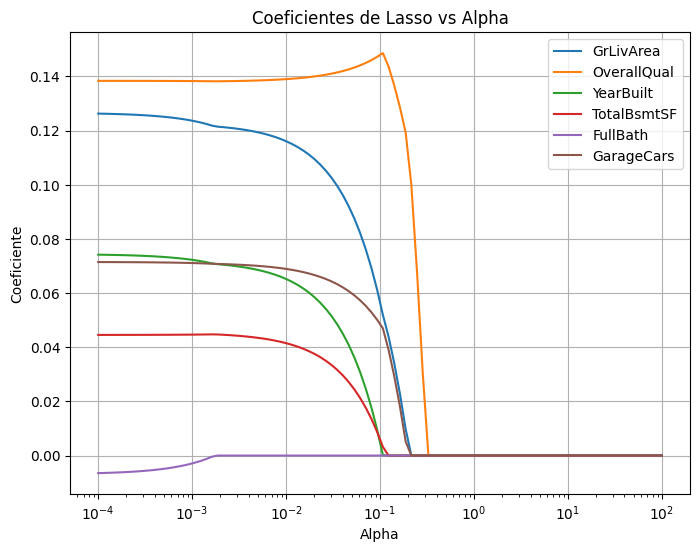

In [15]:
from sklearn.linear_model import lasso_path

# Calcula el camino de Lasso para los mismos datos y alphas
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=alphas)

plt.figure(figsize=(8, 6))
for i, feature in enumerate(numeric_features):
    plt.plot(alphas_lasso, coefs_lasso[i], label=feature)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coeficiente')
plt.title('Coeficientes de Lasso vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

----------

### **9. Regresión Lineal Simple vs. Múltiple:**

#### Entrena un modelo de regresión lineal simple para cada una de las características en `numeric_features` por separado. Compara el coeficiente de cada característica en su modelo simple con su coeficiente en el modelo múltiple (OLS). ¿Por qué son diferentes?

In [38]:
coef_simple = {}

for feature in numeric_features:
    X_train_f = X_train_scaled[[feature]]
    X_test_f = X_test_scaled[[feature]]
    model_simple = LinearRegression()
    model_simple.fit(X_train_f, y_train)
    coef_simple[feature] = model_simple.coef_[0]

# DataFrame para comparar
df_comparacion = pd.DataFrame({
    'Coef_simple': pd.Series(coef_simple),
    'Coef_multiple': ols_model.coef_
}, index=numeric_features)

print("Comparación de coeficientes (simple vs múltiple):")
print(df_comparacion)

print("\n¿Por qué son diferentes?")
print("En la regresión simple, cada coeficiente mide el efecto de esa variable sin controlar por las demás. "
      f"\nEn la múltiple, cada coeficiente mide el efecto de esa variable manteniendo las otras constantes. "
      f"\nSi las variables están correlacionadas entre sí, los coeficientes pueden diferir significativamente entre los dos enfoques.")

Comparación de coeficientes (simple vs múltiple):
             Coef_simple  Coef_multiple
GrLivArea       0.269017       0.126585
OverallQual     0.315453       0.138404
YearBuilt       0.225176       0.074407
TotalBsmtSF     0.233176       0.044540
FullBath        0.227917      -0.006889
GarageCars      0.267236       0.071504

¿Por qué son diferentes?
En la regresión simple, cada coeficiente mide el efecto de esa variable sin controlar por las demás. 
En la múltiple, cada coeficiente mide el efecto de esa variable manteniendo las otras constantes. 
Si las variables están correlacionadas entre sí, los coeficientes pueden diferir significativamente entre los dos enfoques.


----------

### **10. Modelo para Producción:**

#### Si tuvieras que elegir uno de los modelos entrenados para ponerlo en producción y predecir precios de casas para un cliente, ¿cuál elegirías y por qué? Justifica tu respuesta basándote en el rendimiento (R², MSE), la interpretabilidad (coeficientes) y la simplicidad del modelo.

**Respuesta**: Si tuviera que elegir un modelo para producción, elegiría **LassoCV**.  

**Justificación:**

- **Rendimiento:** LassoCV obtiene un R² y un MSE muy similares a RidgeCV y OLS, por lo que su capacidad predictiva es alta.
- **Interpretabilidad:** LassoCV realiza selección automática de variables, dejando coeficientes exactamente en cero para las variables menos relevantes. Esto facilita explicar el modelo al cliente y centrarse solo en las variables importantes.
- **Simplicidad:** Al eliminar variables irrelevantes, el modelo es más simple y menos propenso al sobreajuste.

**En resumen:**  
LassoCV ofrece un buen equilibrio entre precisión, interpretabilidad y simplicidad, lo que lo hace ideal para producción en este caso.